In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [81]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27, 2))
C

tensor([[-0.3625,  0.8061],
        [-0.0141,  0.3245],
        [-0.3917, -0.1756],
        [-1.2910, -0.3684],
        [ 0.0629, -0.4027],
        [ 0.2981,  0.6742],
        [ 0.6336,  2.2001],
        [ 0.2108, -1.9364],
        [-1.3755,  0.4741],
        [-1.4929, -1.1342],
        [-0.8533,  0.4857],
        [ 2.5865, -1.3124],
        [ 0.4318,  0.6035],
        [-1.2847,  0.1226],
        [ 0.3151,  0.6949],
        [-1.5113,  2.3402],
        [ 0.1657, -0.3820],
        [-0.3957, -2.8903],
        [-2.2036, -0.1891],
        [-0.2310, -0.4249],
        [-0.0513, -1.0042],
        [ 0.0159,  0.0969],
        [-0.7654, -0.5587],
        [-0.5171, -1.1641],
        [ 1.0787, -0.1647],
        [-1.3770, -1.6796],
        [ 0.3588,  0.3118]])

In [9]:
emb = C[X]

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100))

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

torch.Size([32, 100])

In [19]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [22]:
logits = h @ W2 + b2

In [23]:
counts = logits.exp()

In [24]:
prob = counts / counts.sum(1, keepdim=True)

In [31]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.5572)

In [ ]:
# ------------ now made respectable :) ---------------

In [16]:
Xtr.shape, Ytr.shape 

(torch.Size([182625, 3]), torch.Size([182625]))

In [28]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn((300), generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

In [29]:
sum(p.nelement() for p in parameters)

10281

In [30]:
for p in parameters:
    p.requires_grad = True

In [20]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [31]:
lri = []
lossi = []
stepi = []

for i in range(30000):

    # minibatch construc
    ix = torch.randint(0, Xtr.shape[0], (32, ), generator=g)
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())


    for p in parameters:
        p.grad = None
    loss.backward()


    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())

print(loss.item())

2.2841203212738037


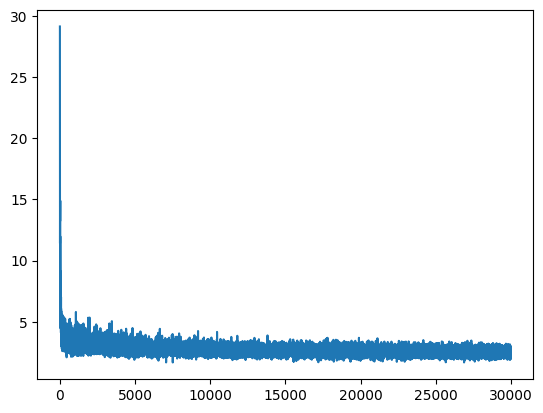

In [32]:
plt.plot(stepi, lossi)

In [27]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss


tensor(2.2671, grad_fn=<NllLossBackward0>)

In [26]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss


tensor(2.2679, grad_fn=<NllLossBackward0>)